In [1]:
# import libraries
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import matplotlib
from math import*
%matplotlib inline

import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import normaltest
import random

from tqdm import tnrange, tqdm_notebook
from IPython import display
import time
import tensorflow as tf

import pypianoroll
from IPython.display import FileLink, FileLinks
from os import walk

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import pandas as pd
import seaborn as sns

Since splitting melody/harmony appears to be a dead end we implement a 'shallow description model' for the entire pianoroll.

According to https://grfia.dlsi.ua.es/repositori/grfia/pubs/130/icmc2004.pdf table 1 the following 12 features are usefull for style classification:

1. Number of notes
2. Pitch average
3. Pitch range
4. Interval range
5. Syncopation
6. Pitch deviation
7. Number of significant silences (we will use >= 16th note silence as significant)
8. Interval distrib. normality
9. Interval deviation
10. IOI deviation <- dropped due to no discernable consecutive notes
11. Note duration deviaton
12. Non-diatonic degrees dev. <- dropped due to no song key information

In [2]:
def extract_features(pianoroll):

    active_pitches = {}
    pitches = []
    intervals = []
    itvRNG = 0 # Interval range
    silsigNUM = 0 # Number of significant silences
    for ts in range(pianoroll.shape[0]):
        if sum(pianoroll[ts]) == 0:
            silsigNUM += 1
        for ps in range(pianoroll.shape[1]):
            if pianoroll[ts,ps] != 0 and ps not in active_pitches:
                pitches.append(ps)
                active_pitches[ps] = [[ts]]
            elif pianoroll[ts,ps] != 0 and (active_pitches[ps][-1][-1]+1 == ts):
                pitches.append(ps)
                active_pitches[ps][-1].append(ts)
            elif pianoroll[ts,ps] != 0:
                pitches.append(ps)
                active_pitches[ps].append([ts])
        if pitches:
            intervals.append((max(pitches)-min(pitches)))
            if intervals[-1] > itvRNG:
                itvRNG = (max(pitches)-min(pitches))
            pitches = []
    
    if len(intervals) >= 20: # D'Agostino's K-squared test only valid for n >= 20
        itvNORM, p = normaltest(intervals) # Interval distribution
        itvDEV = np.std(intervals) # Interval deviation
    else:
        itvNORM = 0
        itvDEV = 0
        
    notNUM = 0 # Number of notes
    pchRNG = 0 # Pitch range
    syncop = 0 # Number of syncopations
    pchAVG = 0 # Pitch average
    pchDEV = 0 # Pitch deviation
    durDEV = 0 # Note duration deviation
    
    if active_pitches:
        notNUM = 0 
        pchRNG = max(active_pitches.keys())-min(active_pitches.keys())
        pitch_count = []
        note_durations = []
        for pitch, durations in active_pitches.items():
            notNUM += len(durations)
            for tss in durations:
                note_durations.append(len(tss))
                if tss[0]%4 != 0:
                    syncop += 1
                for ts in tss:
                    pitch_count.append(pitch)

        pchAVG = np.mean(pitch_count)
        pchDEV = np.std(pitch_count)
        durDEV = np.std(note_durations)
       
    #Plot pianoroll for troubleshooting
    #else: 
        #track = pypianoroll.Track(pianoroll=pianoroll, program=1, is_drum=False, name='Pianoroll')
        #fig, ax = track.plot()
        #plt.show()
        #print([notNUM, pchAVG, pchRNG, itvRNG, syncop, pchDEV, silsigNUM, itvNORM, itvDEV, durDEV])
        
    return [notNUM, pchAVG, pchRNG, itvRNG, syncop, pchDEV, silsigNUM, itvNORM, itvDEV, durDEV]

In [3]:
#Load datasets
path1 = '/home/mjjdg/Documents/M1/Artifiicial and Natural Music Cognition/Assignment/dataV2/classic_train_piano.npy'
path2 = '/home/mjjdg/Documents/M1/Artifiicial and Natural Music Cognition/Assignment/dataV2/jazz_train_piano.npy'
#path3 = '/home/mjjdg/Documents/M1/Artifiicial and Natural Music Cognition/Assignment/dataV2/pop_train_piano.npy'

d1 = np.load(path1)
d2 = np.load(path2)
#d3 = np.load(path3)

print('Using:',len(d1)+len(d2),'samples')
x_test = np.zeros(((len(d1)+len(d2)), 10))
y_test = np.empty((len(d1)+len(d2)), dtype='str')

for i in range(len(d1)):
    pianoroll = d1[i,:,:,0].astype(float)*128
    # Padd below
    x_test[i] = extract_features(np.hstack((np.zeros((64,44), dtype=float), pianoroll)))
    y_test[i] = 'c'
    
for j in range(len(d2)):
    pianoroll = d2[j,:,:,0].astype(float)*128
    # Padd below
    x_test[j+len(d1)] = extract_features(np.hstack((np.zeros((64,44), dtype=float), pianoroll)))
    y_test[j+len(d1)] = 'j'

Using: 25904 samples


/home/mjjdg/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


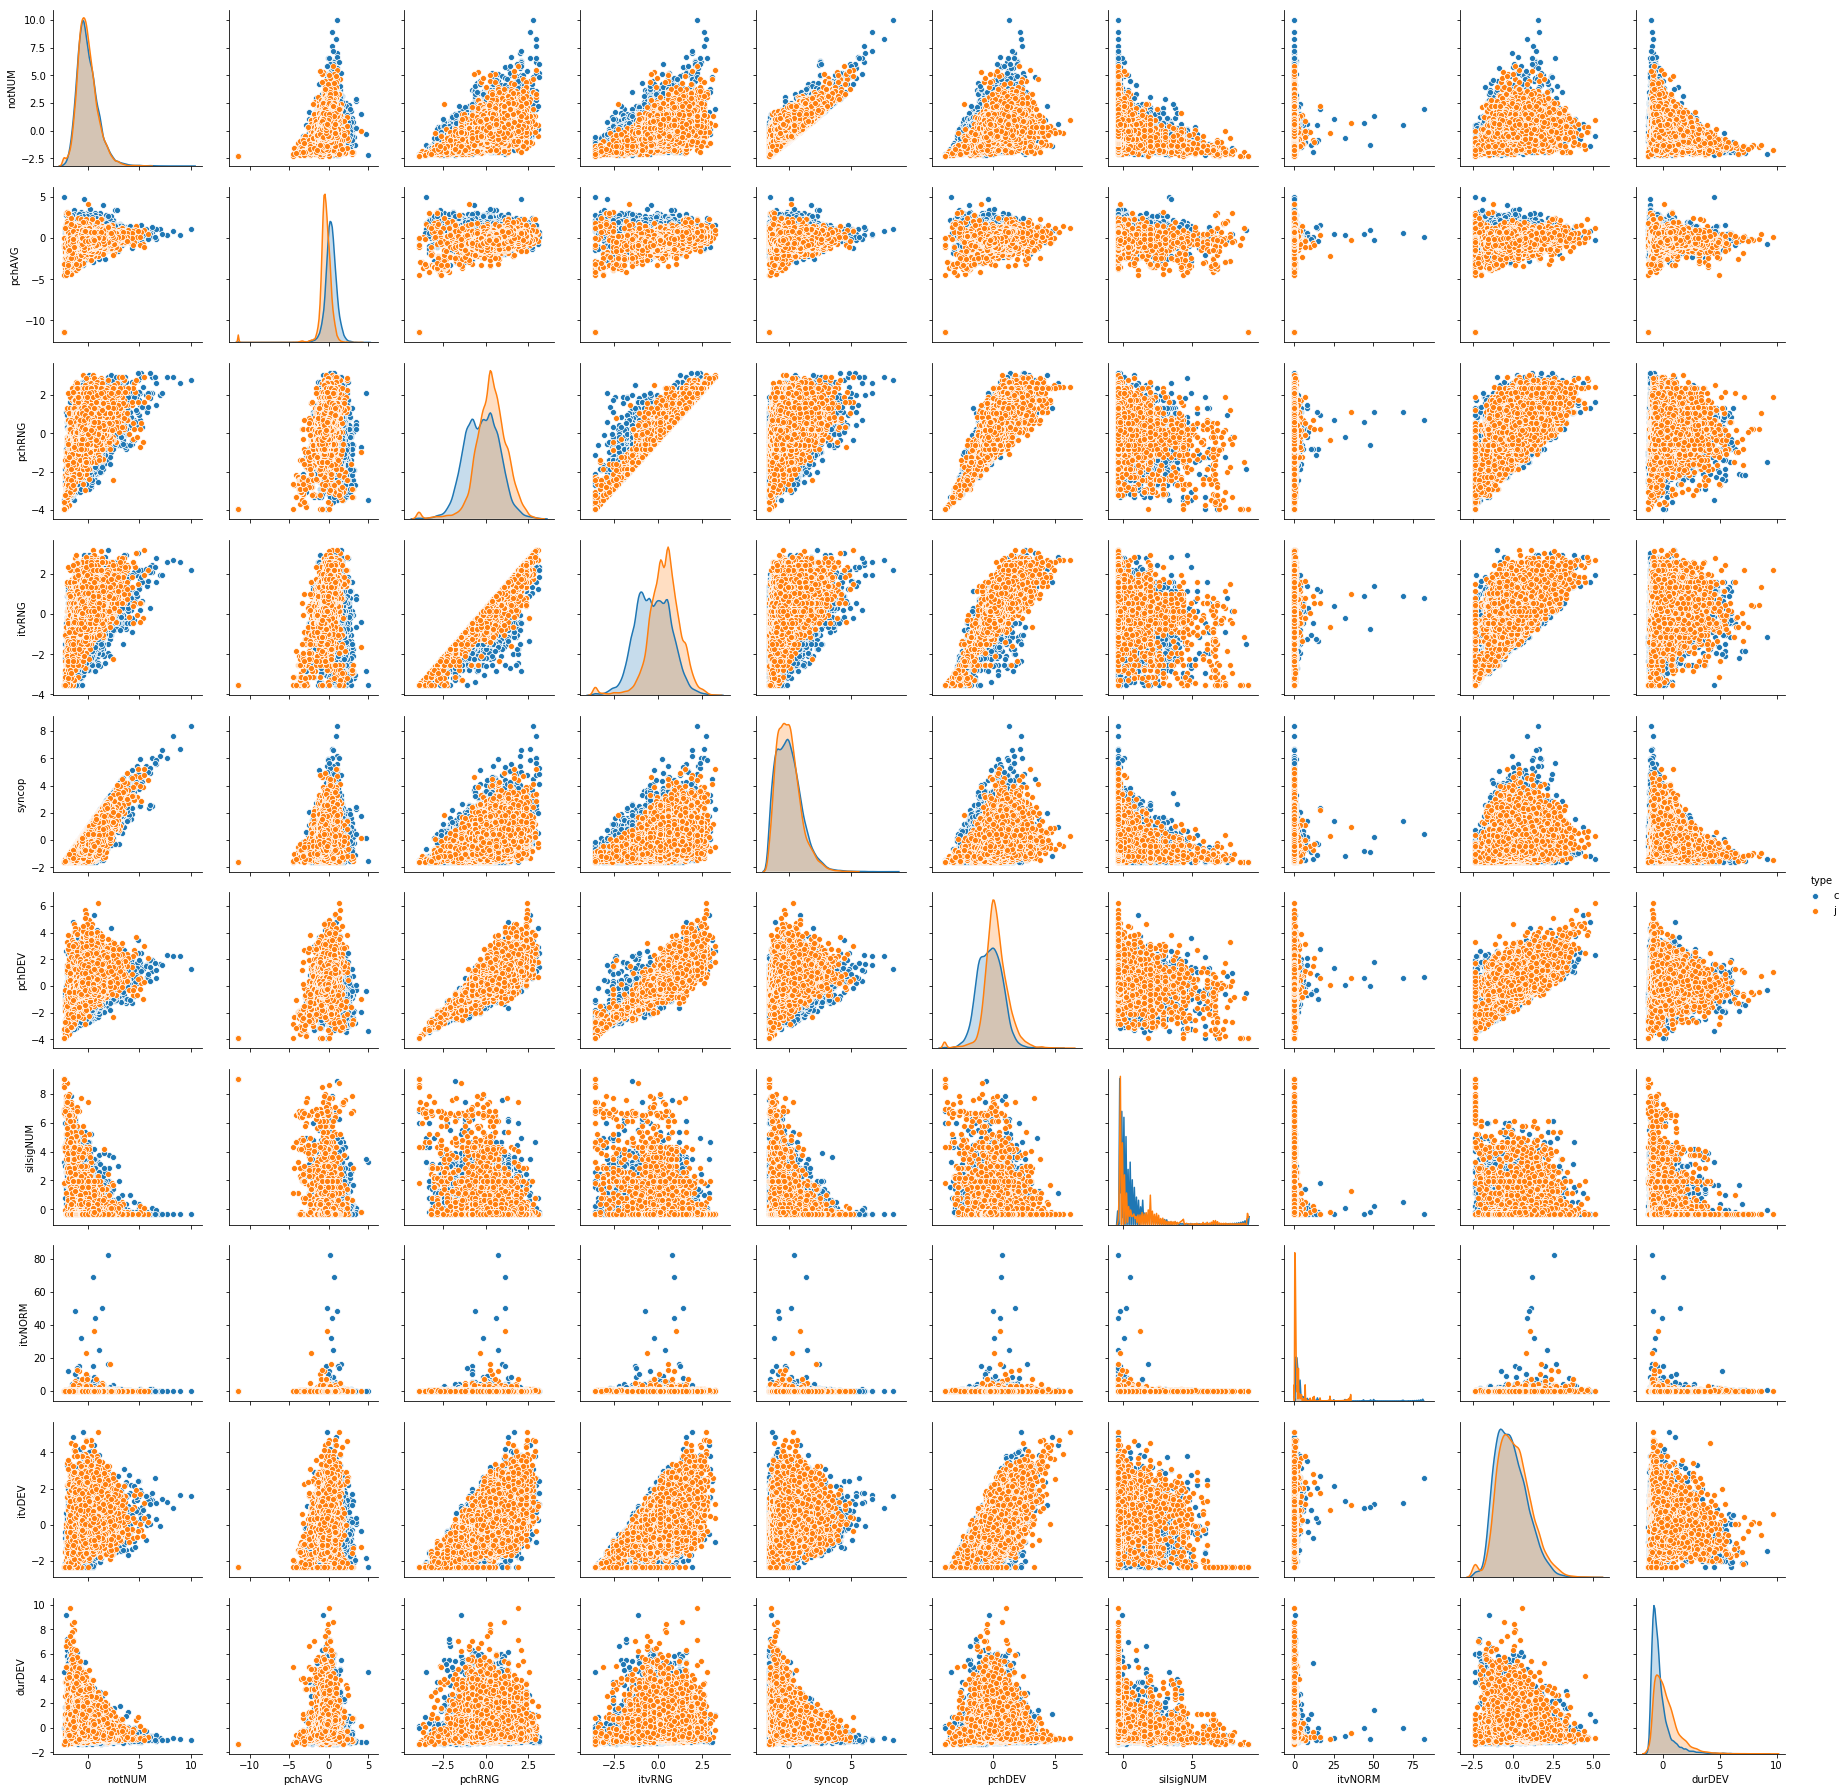

In [4]:
# Normalize x
x_test = StandardScaler().fit_transform(x_test)

data = pd.DataFrame({'type':y_test,'notNUM':x_test[:,0], 'pchAVG':x_test[:,1], 'pchRNG':x_test[:,2],
                    'itvRNG':x_test[:,3],'syncop':x_test[:,4],'pchDEV':x_test[:,5],'silsigNUM':x_test[:,6],
                    'itvNORM':x_test[:,7],'itvDEV':x_test[:,8],'durDEV':x_test[:,9]})

sns.pairplot(data, hue="type")

/home/mjjdg/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


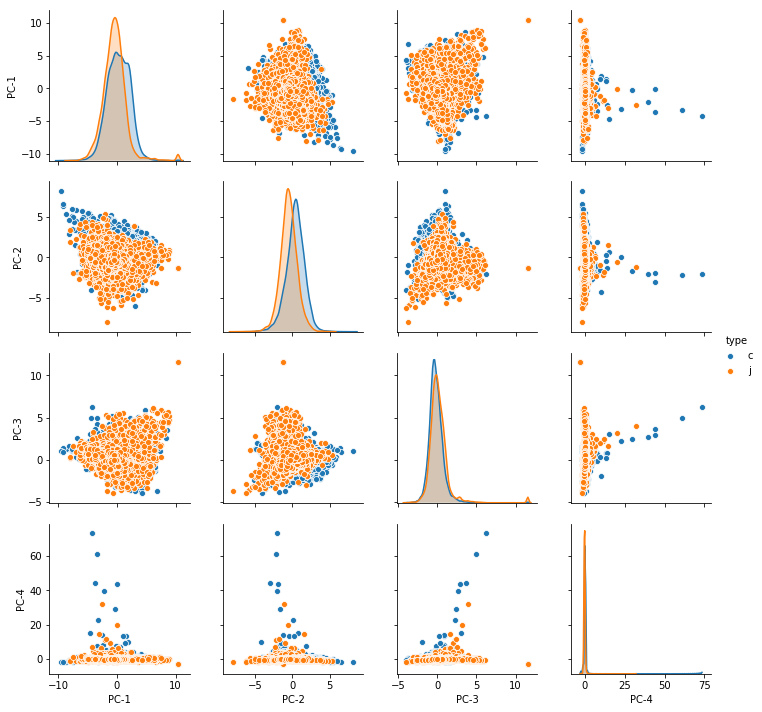

In [5]:
# PCA
pca = PCA(n_components=4)

PCA_x = pca.fit_transform(x_test)

data = pd.DataFrame({'type':y_test,'PC-1':PCA_x[:,0], 'PC-2':PCA_x[:,1], 'PC-3':PCA_x[:,2],
                    'PC-4':PCA_x[:,3]})

sns.pairplot(data, hue="type")

In [6]:
def square_rooted(x):
 
    return round(sqrt(sum([a*a for a in x])),3)
 
def cosine_similarity(x,y):
    numerator = sum(a*b for a,b in zip(x,y))
    denominator = square_rooted(x)*square_rooted(y)
    
    return round(numerator/float(denominator),3)

In [31]:
indices = []
while(len(indices) < 15):
    index = random.randint(0, len(d1))
    if(index not in indices and x_test[index][0] > 0):
        indices.append(index)

pairs = {}
for index in indices:
    similarities = [cosine_similarity(x_test[index],x) for x in x_test[len(d1):]]
    pairs[index] = similarities.index(max(similarities))
        
for k, v in pairs.items():
    print('Classical index:',k,'\t Jazz index:',v,"\tCosine simularity:",cosine_similarity(x_test[k],x_test[v+len(d1)]))

Classical index: 3052 	 Jazz index: 6060 	Cosine simularity: 0.945
Classical index: 8354 	 Jazz index: 9595 	Cosine simularity: 0.967
Classical index: 12115 	 Jazz index: 6964 	Cosine simularity: 0.981
Classical index: 3659 	 Jazz index: 2013 	Cosine simularity: 0.929
Classical index: 13681 	 Jazz index: 1633 	Cosine simularity: 0.836
Classical index: 5836 	 Jazz index: 2832 	Cosine simularity: 0.946
Classical index: 6004 	 Jazz index: 3660 	Cosine simularity: 0.946
Classical index: 4886 	 Jazz index: 2772 	Cosine simularity: 0.968
Classical index: 2018 	 Jazz index: 4438 	Cosine simularity: 0.989
Classical index: 1250 	 Jazz index: 4275 	Cosine simularity: 0.907
Classical index: 4446 	 Jazz index: 4831 	Cosine simularity: 0.99
Classical index: 5089 	 Jazz index: 10088 	Cosine simularity: 0.948
Classical index: 3003 	 Jazz index: 9451 	Cosine simularity: 0.953
Classical index: 10382 	 Jazz index: 11202 	Cosine simularity: 0.939
Classical index: 10913 	 Jazz index: 4138 	Cosine simulari

/home/mjjdg/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


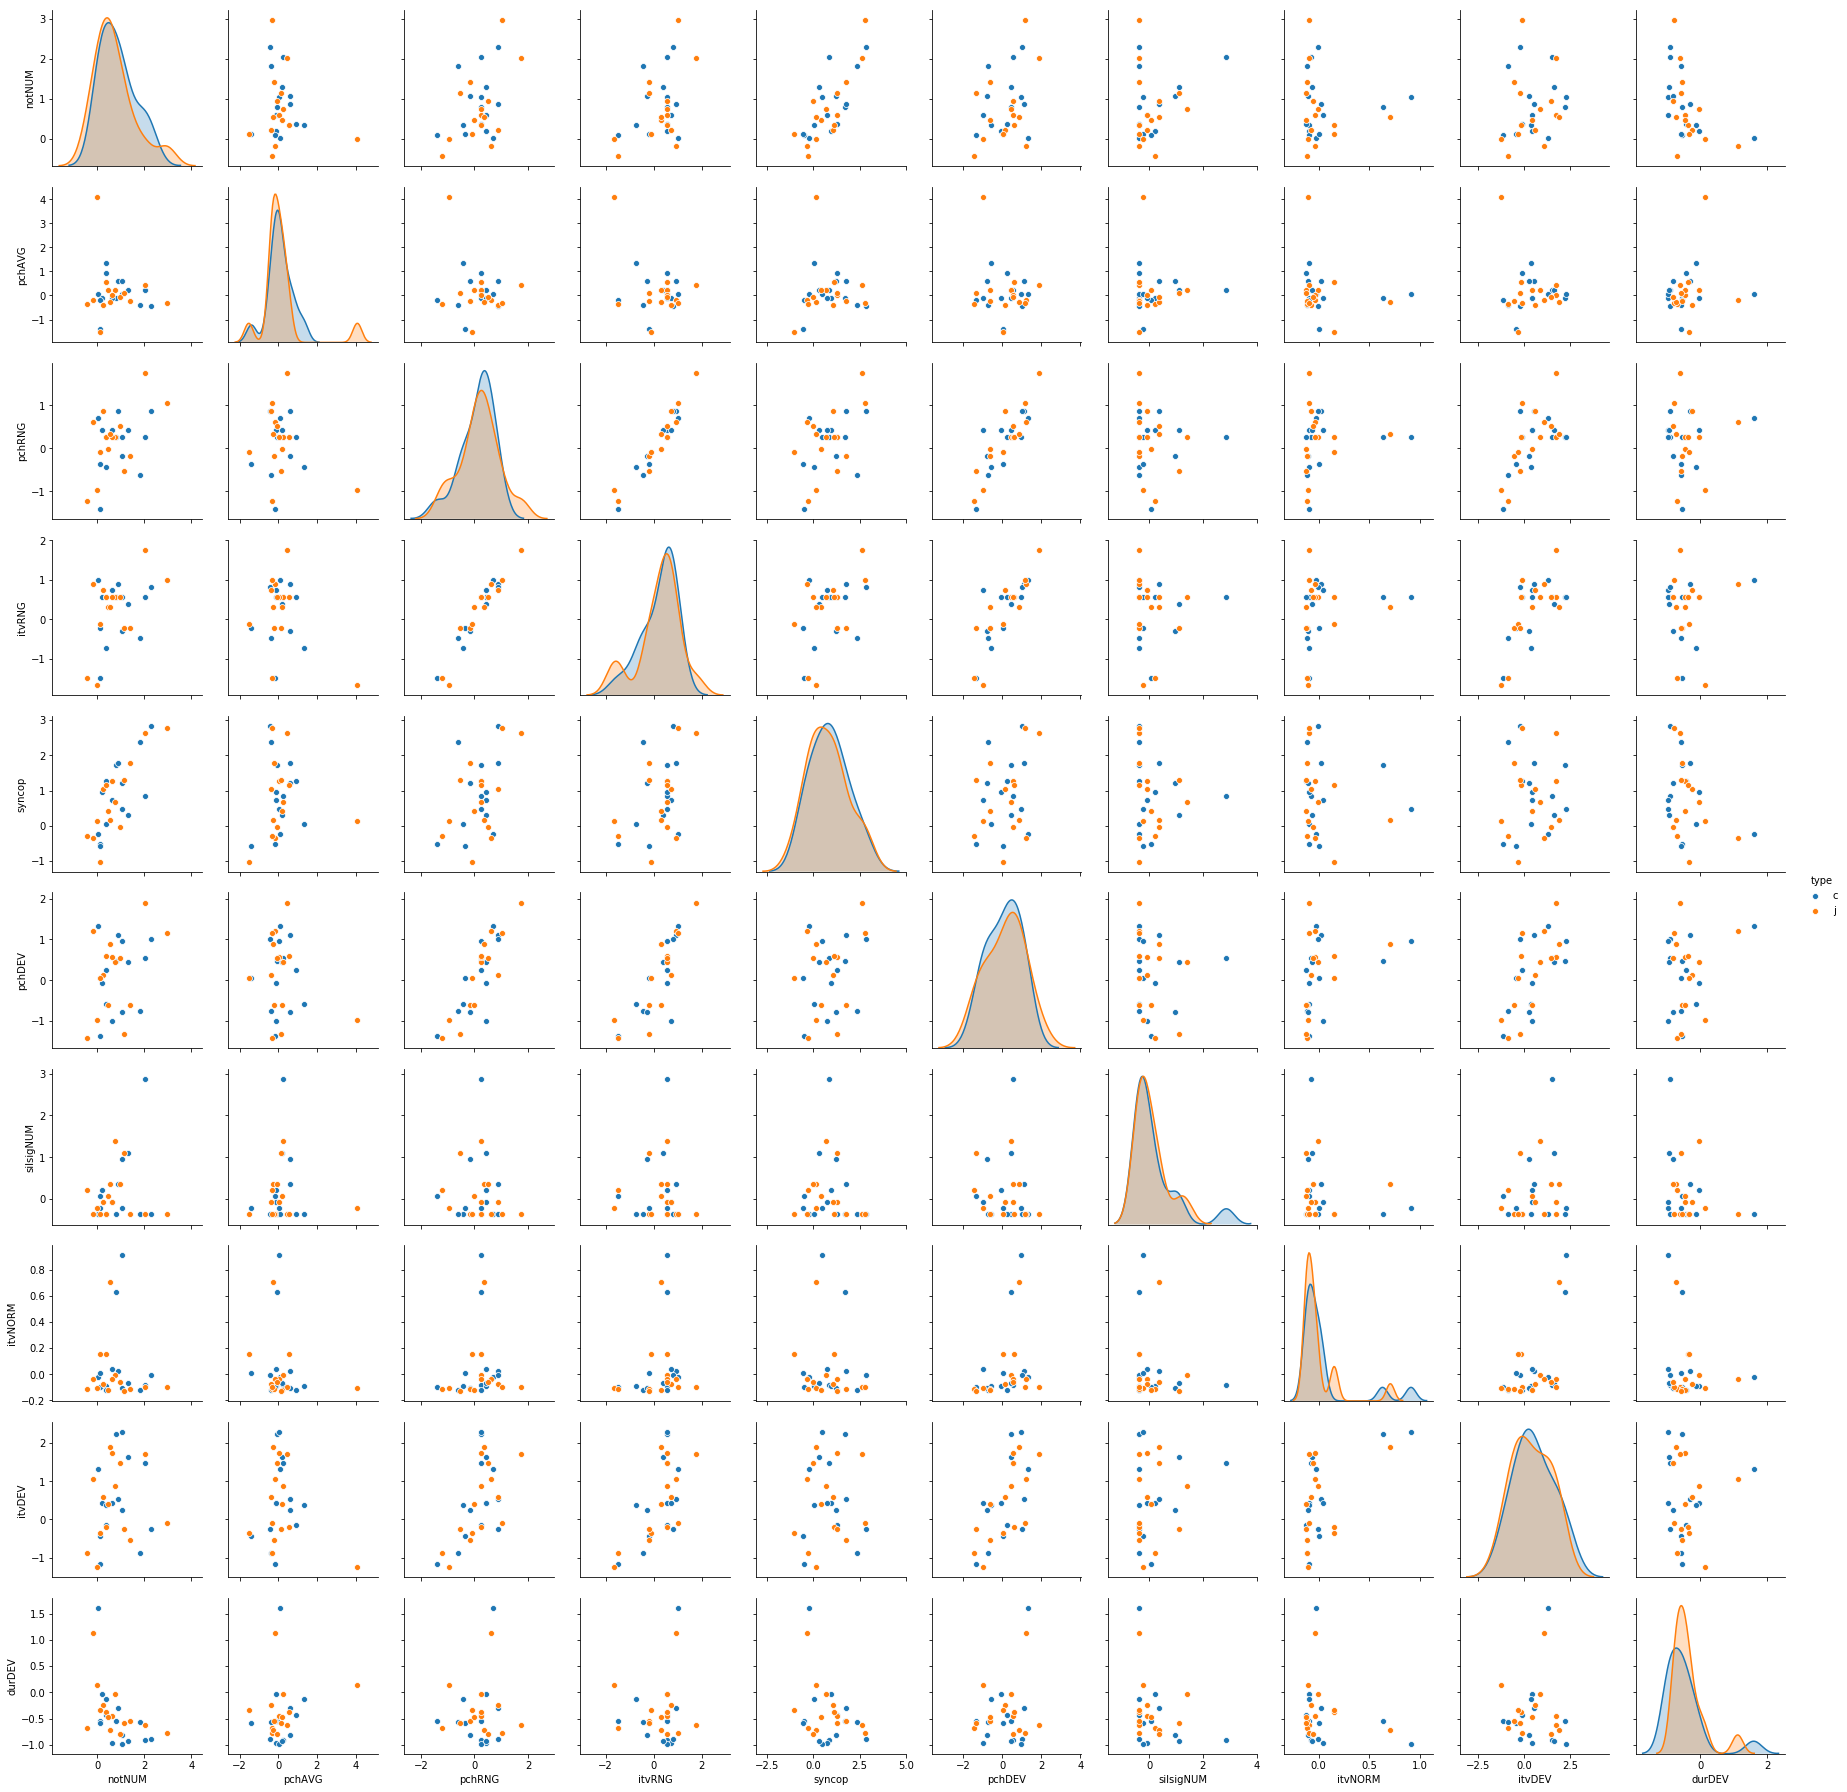

In [32]:
y_test2 = [y_test[i] for i in pairs.keys()]+[y_test[j+len(d1)] for j in pairs.values()]
x_test2 = [x_test[i] for i in pairs.keys()]+[x_test[j+len(d1)] for j in pairs.values()]

data = pd.DataFrame({'type':y_test2,'notNUM':[x[0] for x in x_test2], 'pchAVG':[x[1] for x in x_test2], 'pchRNG':[x[2] for x in x_test2],
                    'itvRNG':[x[3] for x in x_test2],'syncop':[x[4] for x in x_test2],'pchDEV':[x[5] for x in x_test2],'silsigNUM':[x[6] for x in x_test2],
                    'itvNORM':[x[7] for x in x_test2],'itvDEV':[x[8] for x in x_test2],'durDEV':[x[9] for x in x_test2]})

sns.pairplot(data, hue="type")

In [35]:
classical = np.asarray([d1[x] for x in pairs.keys()])
jazz = np.asarray([d2[x] for x in pairs.values()])

np.save('ClassicalCandidates', classical)
np.save('JazzCandidates', jazz)

In [36]:
test = np.load('ClassicalCandidates.npy')
print(test.shape)

(15, 64, 84, 1)
